In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append("../utils/")

In [3]:
from utils import r6io
from utils import features
from utils import plotting

In [14]:
pd.options.display.float_format = '{:.6f}'.format

In [5]:
df = r6io.read_player_csv('../data/leaderboard-pages.csv', 'ps4', **{"nrows": 10000})
df = df.reset_index()

In [6]:
numbers = features.columns_for_stats(df)

In [7]:
df_stats = df[numbers].copy().fillna(0)

In [8]:
df_stats.head(1).T

,0
stats.casual.deaths,777.0000
stats.casual.kd,1.4860
stats.casual.kills,1155.0000
stats.casual.losses,133.0000
stats.casual.playtime,291203.0000
stats.casual.wins,221.0000
stats.casual.wlr,1.6620
stats.overall.assists,557.0000
stats.overall.barricades_built,1084.0000
stats.overall.bullets_fired,92244.0000


In [9]:
df_stats['stats.overall.playtime'] = features.calc_total_playtime(df_stats)

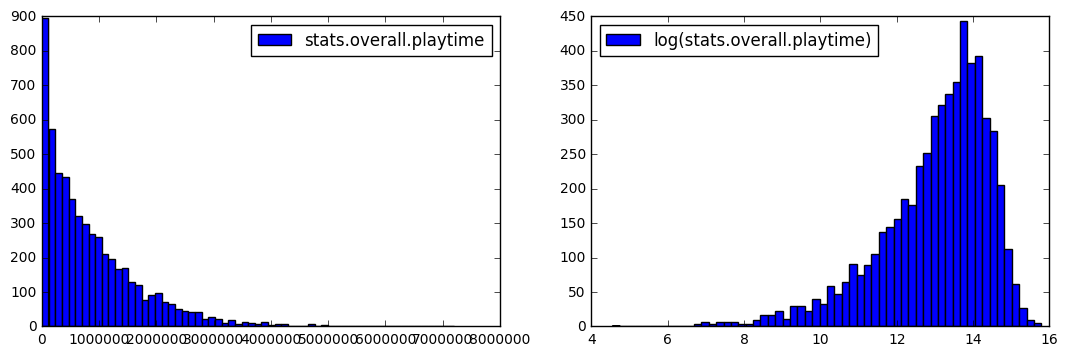

In [10]:
X = df_stats['stats.overall.playtime'].replace(np.inf, 0)
fig = plt.figure(figsize=(13,4), dpi=100)

plt.subplot(1, 2, 1)
plt.hist(X, bins='auto', label=X.name)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(np.log(X), bins='auto', label="log({})".format(X.name))
plt.legend(loc='upper left')

plt.show()

In [17]:
df_stats_normed = df_stats.apply(features.normalize_for_playtime, frame=df_stats).fillna(0)

In [18]:
df_stats_normed.head(10)

,stats.casual.deaths,stats.casual.kd,stats.casual.kills,stats.casual.losses,stats.casual.playtime,stats.casual.wins,stats.casual.wlr,stats.overall.assists,stats.overall.barricades_built,stats.overall.bullets_fired,...,stats.progression.level,stats.progression.xp,stats.ranked.deaths,stats.ranked.kd,stats.ranked.kills,stats.ranked.losses,stats.ranked.playtime,stats.ranked.wins,stats.ranked.wlr,stats.overall.playtime
0,0.002668,0.000005,0.003966,0.000457,1.000000,0.000759,0.000006,0.001095,0.002131,0.181376,...,0.000195,0.075671,0.002903,0.000008,0.004798,0.000345,1.000000,0.000515,0.000007,1.000000
1,0.005427,0.000059,0.008275,0.000308,1.000000,0.000731,0.000091,0.001861,0.000465,0.274528,...,0.000362,0.080766,0.004720,0.000009,0.005566,0.000365,1.000000,0.000497,0.000011,1.000000
2,0.002989,0.000372,0.006329,0.000352,1.000000,0.001231,0.000615,0.001230,0.000416,0.163090,...,0.000572,0.070113,0.003247,0.000027,0.004515,0.000288,1.000000,0.000538,0.000036,1.000000
3,0.002934,0.000130,0.005208,0.000513,1.000000,0.000733,0.000105,0.001578,0.000162,0.233010,...,0.000728,0.105299,0.002526,0.000122,0.003428,0.000180,1.000000,0.000722,0.000361,1.000000
4,0.003441,0.000002,0.002520,0.000535,1.000000,0.000609,0.000003,0.000928,0.001695,0.088812,...,0.000081,0.031565,0.003302,0.000000,0.002404,0.000405,1.000000,0.000354,0.000001,1.000000
5,0.003648,0.000002,0.002653,0.000700,1.000000,0.000550,0.000002,0.001049,0.002235,0.100578,...,0.000207,0.042043,0.003532,0.000017,0.001875,0.000500,1.000000,0.000406,0.000025,1.000000
6,0.003379,0.000005,0.002560,0.000609,1.000000,0.000628,0.000006,0.001048,0.001472,0.131502,...,0.000167,0.034902,0.003326,0.000002,0.002703,0.000415,1.000000,0.000415,0.000003,1.000000
7,0.003834,0.000548,0.003834,0.001095,1.000000,0.000548,0.000274,0.001095,0.005476,0.187842,...,0.001643,0.102957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
8,0.003379,0.000005,0.003661,0.000610,1.000000,0.000707,0.000005,0.001225,0.001516,0.148206,...,0.000160,0.015950,0.003590,0.000003,0.003983,0.000360,1.000000,0.000476,0.000003,1.000000
9,0.003123,0.000002,0.002673,0.000545,1.000000,0.000607,0.000003,0.000999,0.001873,0.115198,...,0.000208,0.042227,0.002509,0.000028,0.002832,0.000273,1.000000,0.000472,0.000043,1.000000


In [52]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [61]:
X = df_stats_normed.values
n_clusters = 3
batch_size = 45
order = range(n_clusters)

In [62]:
pca = PCA(n_components=2, svd_solver='full')
X = pca.fit_transform(X)

In [63]:
mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)

mbk.fit(pca.fit_transform(X))

MiniBatchKMeans(batch_size=45, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=3,
        n_init=10, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [64]:
from matplotlib.pyplot import cm 
colors = cm.rainbow(np.linspace(0,1,n_clusters))

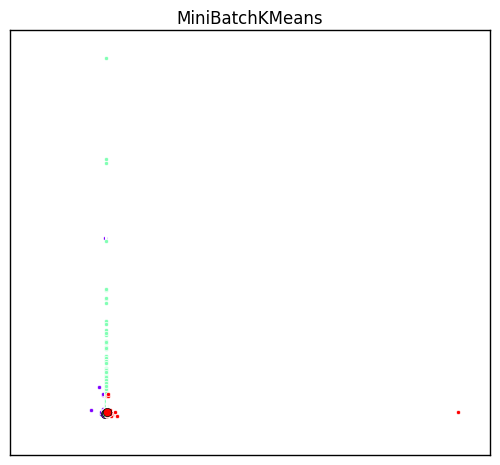

In [66]:
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.

mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# MiniBatchKMeans
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.show()

array([2, 2, 2, ..., 1, 2, 2])